In [1]:
!pip install tensorflow_probability tensorflow_ranking tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 42.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:0000:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing i

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1
from keras.optimizers import Adam

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import pickle

import VAE
from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder, get_auth_model
from VAE_stats import VAE_stats
from scaler import CustomScaler


import datetime, csv, os, re, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from scaler import CustomScaler

from featurize import filter, featurize
from sklearn.neural_network import MLPClassifier


2023-02-22 14:44:48.874119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 14:44:50.020660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:44:50.020758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-22 14:44:50.020769: W tensorfl

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

import pickle

from featurize import featurize
from visualise import *

from scaler import CustomScaler

from WAE import WAE
from WAE_stats import WAE_stats

class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)


def get_new_auth_model(input_dim=(200,16), output_dim=2, final_act=None):
    #input_dim = (200,16)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    xs = []
    
    for i in range(6): # input_dim[1]
        
        x = SplitLayer(i)(inputs)
        reshaped = Reshape((200, 1))(x)
        
        x = Conv1D(100, 10, strides=2, padding="same")(reshaped)   #, kernel_regularizer=l2(1e-5)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        """
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=7, strides=None, padding="valid")(x)
        """
        xs.append(x)
    
    
    x = layers.Concatenate()(xs)
    
    
    x = LSTM(50)(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.1)(x)
    
    """
    x = layers.Flatten()(x)
    x = Dense(25, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = Dropout(0.1)(x)
    """
    
    if final_act is None:
        x = Dense(output_dim)(x)
        x = layers.BatchNormalization()(x)
    else:
        x = Dense(output_dim, activation=final_act)(x)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier_v2")
    
    return model
get_new_auth_model().summary()

Model: "LSTM_classifier_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 16)]    0           []                               
                                                                                                  
 split_layer (SplitLayer)       (None, 200)          0           ['input_1[0][0]']                
                                                                                                  
 split_layer_1 (SplitLayer)     (None, 200)          0           ['input_1[0][0]']                
                                                                                                  
 split_layer_2 (SplitLayer)     (None, 200)          0           ['input_1[0][0]']                
                                                                                 

In [3]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()

file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]

#from featurize import filter as _filter, ORDER, CUTOFF, FILTER_INDICES
#x_data = _filter(x_data, FILTER_INDICES, ORDER, CUTOFF)


y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)

x_features = np.load(f"data/processed/x_{file_name}_features.npy")
###


user_restriction_map = y_user.argmax(axis=1) <= 8

y_user = y_user[user_restriction_map][:,:9]
y_intent = y_intent[user_restriction_map]
y_gesture = y_gesture[user_restriction_map]
train_gesture_map = train_gesture_map[user_restriction_map]
test_gesture_map = test_gesture_map[user_restriction_map]
x_data = x_data[user_restriction_map]
x_features = x_features[user_restriction_map]

_map = (train_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]

def show_visuals(vae, mode="train"):
    if mode == "train":
        _map = (train_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

        user_x = x_data[_map]
        user_y = y_user.argmax(axis=1)[_map]
    else:
        _map = (test_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 11))

        user_x = x_data[_map]
        user_y = y_user.argmax(axis=1)[_map]
    
    latent_space_means, latent_space_stds, latent_space = vae.encoder(vae.scaler.transform(x_data[:10]))

    plt.scatter(latent_space_means[:,0], latent_space_means[:,1], c = range(10), label="means")
    plt.scatter(latent_space[:,0], latent_space[:,1], label="sampled", c = range(10), s=10)

    plt.legend()
    
    plot_label_clusters(vae, vae.scaler.transform(user_x), user_y)
    visualise(vae, vae.scaler.transform(user_x), user_y, 10)
    plot_reconstructed_curves(vae, vae.scaler.transform(user_x), channel=0)


In [4]:
for i in range(9):
    print (i, end = ' ')
    print(sum((y_user.argmax(axis=1) == i) ))

y_user = y_user[:, :9]
print(y_user.shape)

0 2791
1 1402
2 10866
3 520
4 6868
5 947
6 1824
7 988
8 6467
(32673, 9)


In [5]:

from tensorflow.keras import regularizers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class EmbeddingModel(keras.Model):
    def __init__(self, latent_dim = 2, **kwargs):
        super(EmbeddingModel, self).__init__(**kwargs)
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
        
        """
        inputs = keras.Input(shape=(self.num_features,))
        x = inputs
        x = layers.Dense(50, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(20, activation="relu", kernel_regularizer=l2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        out = layers.Dense(latent_dim, kernel_regularizer=l2(1e-3))(x)
        #out = layers.BatchNormalization()(x)
        self.embedding = keras.Model(inputs, out, name="embedding")
        """
        self.embedding = get_new_auth_model((200,6), output_dim=latent_dim)
        
        inputs2 = keras.Input(shape=(latent_dim,))
        out2 = layers.Dense(10, activation="softmax")(inputs2)
        self.classifier = keras.Model(inputs2, out2, name="classifier")
        self.means = tf.Variable(np.zeros((10, latent_dim)), dtype="float32")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        feature_data, y_user_one_hot = data
        with tf.GradientTape() as tape:
                      
            embeddings = self.embedding(feature_data)
            
            embeddings = tf.expand_dims(embeddings, 1)
            predictions = tf.nn.softmax(-tf.norm(embeddings - self.means, axis=-1, ord=2), axis=-1)
            
            """
            predictions = self.classifier(embeddings)
            """
            classification_loss = tf.keras.losses.CategoricalCrossentropy()(y_user_one_hot, predictions)
            
            total_loss = classification_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Unpack the data
        x, y = data
        
        embeddings = self.embedding(x)
            
        embeddings = tf.expand_dims(embeddings, 1)
        y_pred = tf.nn.softmax(-tf.norm(embeddings - self.means, axis=-1, ord=2), axis=-1)

        loss = tf.keras.losses.CategoricalCrossentropy()(y, y_pred)
        #y_pred = self.classifier(embeddings)
        #loss = tf.keras.losses.CategoricalCrossentropy()(y, y_pred)
        
        self.val_loss_tracker.update_state(loss)

        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


class cVAE_features(keras.Model):
    def __init__(self, latent_dim, num_features, conditioning_latent_dim, beta = 0.001, alpha = 0.1, **kwargs):
        super(cVAE_features, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        self.num_features = num_features
        self.conditioning_latent_dim = conditioning_latent_dim
        
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
        
        self.beta = beta
        self.alpha = alpha
    
    def get_encoder(self):
        inputs = keras.Input(shape=(self.num_features + self.conditioning_latent_dim,))
        x = inputs
        x = layers.Dense(50, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.Dense(25, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.Dense(10, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x) # kernel_initializer=keras.initializers.Zeros()
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var", kernel_initializer=keras.initializers.Zeros())(x)

        z = Sampling()([z_mean, z_log_var])

        encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
    
    def get_decoder(self):
        inputs = keras.Input(shape=(self.latent_dim + self.conditioning_latent_dim,))
        x = inputs
        x = layers.Dense(10, activation="relu")(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.Dense(25, activation="relu")(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.Dense(50, activation="relu")(x)
        x = layers.Dropout(rate=0.2)(x)
        
        x = layers.Dense(self.num_features)(x)
        
        decoder = keras.Model(inputs, x, name="decoder")
        return decoder
    
    def save_model(self, folder, tag):
        
        with open(f'data/models/{folder}/enc_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.encoder, f)

        with open(f'data/models/{folder}/dec_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.decoder, f)
            
    def load_model(self, folder, tag):
        
        with tf.keras.utils.custom_object_scope({'Sampling': Sampling, "SplitLayer":SplitLayer}):
            with open(f'data/models/{folder}/enc_{tag}.pickle', 'rb') as pickle_file:
                self.encoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/dec_{tag}.pickle', 'rb') as pickle_file:
                self.decoder = pickle.load(pickle_file)
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        data, conditional_embedding = data
        cat_data = tf.concat([data, conditional_embedding], 1)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(cat_data)
        
            z_cat = tf.concat([z, conditional_embedding], 1)
            
            reconstruction = self.decoder(z_cat)
            
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        data, conditional_embedding = data
        cat_data = tf.concat([data, conditional_embedding], 1)
        
        z_mean, z_log_var, z = self.encoder(cat_data)
        
        z_cat = tf.concat([z, conditional_embedding], 1)
            
        reconstruction = self.decoder(z_cat)
            
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction))
        
        self.val_loss_tracker.update_state(reconstruction_loss)

        
        return {m.name: m.result() for m in self.metrics}


In [6]:
train_map = (y_gesture.argmax(axis=1) != 0) & (test_gesture_map == 0)

data_train = x_data[train_map] # (y_intent == 0)
feature_data_train = x_features[train_map]
labels_train = y_intent[train_map] # (y_intent == 0)


 # 
data_test = x_data[~train_map] # [ (train_gesture_map == 1)] # []
feature_data_test = x_features[~train_map]
labels_test = y_intent[~train_map] # [(train_gesture_map == 1)]

scaler = CustomScaler()
scaler.CHANNELS = 6
data_train = scaler.fit_and_transform(data_train)
data_test = scaler.transform(data_test)

In [7]:
split = sklearn.model_selection.ShuffleSplit(n_splits=2, test_size=.25, random_state = 0)

train_map, val_map = list(split.split(data_train, labels_train))[0]

In [8]:
#embedding_model = EmbeddingModel(2)
#embedding_model.compile(Adam())

#embedding_model.fit(data_train[train_map],labels_train[train_map],
#                    validation_data = (data_train[val_map],labels_train[val_map]),
#                    epochs=100, batch_size=128)
"""
gesture_model = get_new_auth_model((200,6), 10, "softmax")

gesture_model.compile(Adam(), loss="sigmoid")

gesture_model.fit(data_train[train_map],labels_train[train_map],
                   validation_data = (data_train[val_map],labels_train[val_map]),
                  epochs=100, batch_size=128)
   """
user_model = get_new_auth_model((200,6), 1, "sigmoid")

user_model.compile(Adam(), loss="binary_crossentropy")

user_model.fit(data_train[train_map],labels_train[train_map],
                   validation_data = (data_train[val_map],labels_train[val_map]),
                  epochs=20, batch_size=128)

Epoch 1/20
86/86 [==============================] - 11s 33ms/step - loss: 0.2405 - val_loss: 0.0734
Epoch 2/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0760 - val_loss: 0.0597
Epoch 3/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0571 - val_loss: 0.0486
Epoch 4/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0436 - val_loss: 0.0448
Epoch 5/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0370 - val_loss: 0.0538
Epoch 6/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0288 - val_loss: 0.0495
Epoch 7/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0309 - val_loss: 0.0465
Epoch 8/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0254 - val_loss: 0.0383
Epoch 9/20
86/86 [==============================] - 2s 22ms/step - loss: 0.0202 - val_loss: 0.0412
Epoch 10/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0163 - val_loss: 0.0511
Epoch 11

In [11]:
def evaluate(labels_pred, labels_scores, labels_test):
    fmeasure = f1_score(labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) # macro vs binary
    auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, average = "macro", labels = np.unique(labels_pred))


    scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
    scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]
    eer_theta, eer = get_eer(scores_legit, scores_adv)
    far_theta, far = get_far_when_zero_frr(scores_legit, scores_adv)

    print(f"fmeasure {fmeasure} | auroc {auroc} | eer {eer} | far {far}" )

intent_model = user_model

labels_scores = intent_model.predict(data_test)
labels_pred = labels_scores >= 0.5

evaluate(labels_pred, labels_scores, labels_test)

566/566 [==============================] - 3s 5ms/step
fmeasure 0.8956743002544528 | auroc 0.9936978950063853 | eer 0.023783660168086418 | far 0.8017837745126065


In [12]:
model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced").fit(feature_data_train, labels_train)
labels_pred = model.predict(feature_data_test)
labels_scores = model.predict_proba(feature_data_test)[:, 1]
   
evaluate(labels_pred, labels_scores, labels_test)         


fmeasure 0.8472095150960659 | auroc 0.992257511985134 | eer 0.02418386598822253 | far 0.36807501000514553


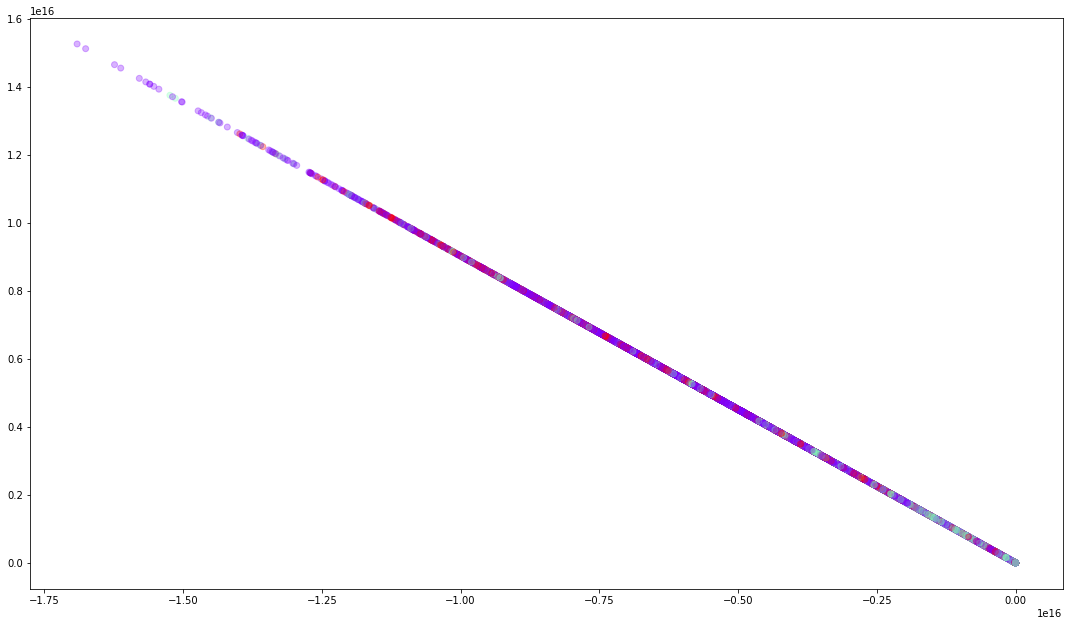

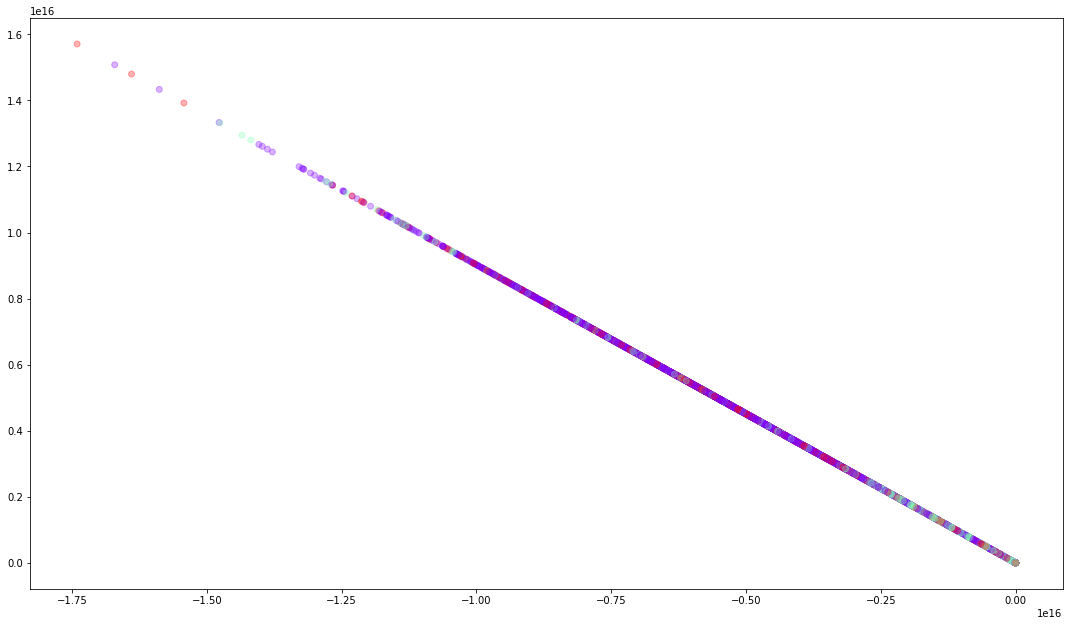

In [19]:
train_embeddings = embedding_model.embedding(data_train[train_map])
val_embeddings = embedding_model.embedding(data_train[val_map])


fig = plt.figure()
ax = fig.add_subplot() #projection='3d') # embs[:, 2],

ax.scatter(train_embeddings[:,0], train_embeddings[:,1], cmap="rainbow", c = labels_train[train_map].argmax(axis=1), alpha=0.3)
fig.set_size_inches(18.5, 10.5)

fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(val_embeddings[:,0], val_embeddings[:,1],  cmap="rainbow", c = labels_train[val_map].argmax(axis=1), alpha= 0.3)

fig.set_size_inches(18.5, 10.5)
plt.show()

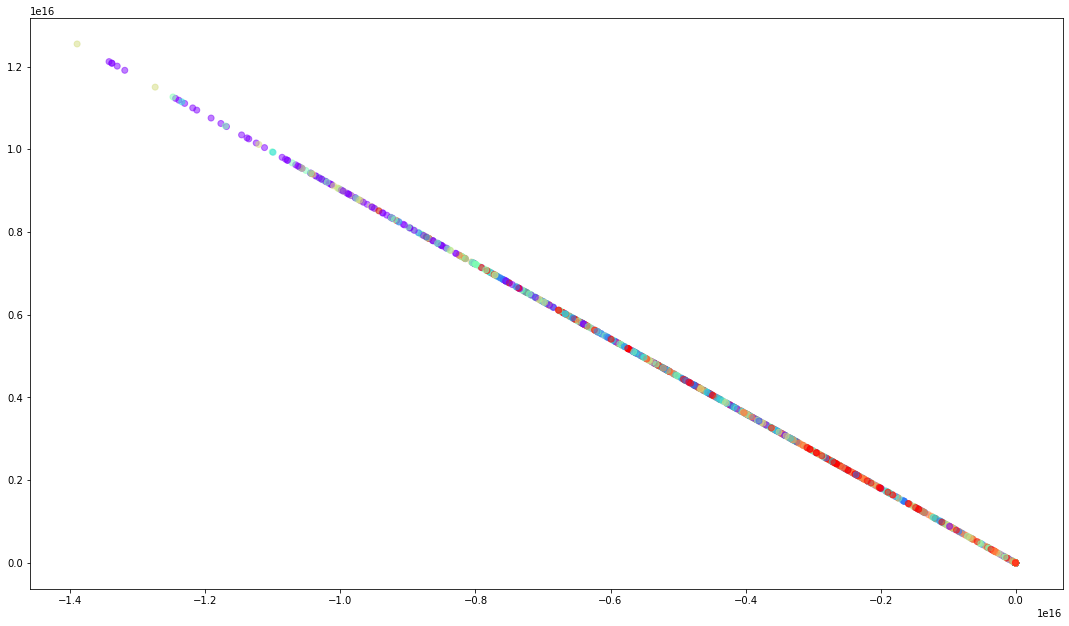

In [20]:
test_embeddings = embedding_model.embedding(data_test)


fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(test_embeddings[:,0], test_embeddings[:,1],  cmap="rainbow", c = labels_test.argmax(axis=1), alpha=0.5)

fig.set_size_inches(18.5, 10.5)
plt.show()

In [97]:
new_vae = cVAE_features(10, feature_data_train.shape[1], 3)
new_vae.compile(Adam())
new_vae.fit(feature_data_train[train_map], train_embeddings,
            epochs=500, batch_size=128,
            validation_data=(feature_data_train[val_map], val_embeddings))

NameError: name 'feature_data_train' is not defined

tf.Tensor(
[[-0.17557123 -1.7420337  -0.20630853 ... -0.4075591   0.6376725
   0.07492887]
 [ 1.0621558   0.7528581  -0.8369732  ...  1.1456081   2.7858794
   1.1045278 ]
 [ 0.43703994  0.20817971 -1.0336369  ...  0.44192412  2.3452709
   1.1402023 ]
 ...
 [-0.38430798  0.30692646  1.4001826  ...  0.9414367   0.9039803
  -0.23173845]
 [-0.21485437  0.7433752   0.33132505 ...  0.6025061  -0.6940012
  -0.5845133 ]
 [-0.0328111  -0.9207284   0.00365493 ... -0.8795131   1.3138345
   0.8502835 ]], shape=(1799, 10), dtype=float32)


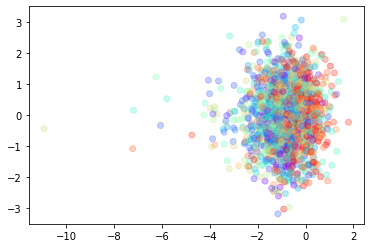

In [22]:
new_vae_embs_train = new_vae.encoder(tf.concat([feature_data_train[train_map], train_embeddings], 1))[2]
print(new_vae_embs_train)

fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(new_vae_embs_train[:,0], new_vae_embs_train[:,1],  cmap="rainbow", c = labels_train[train_map].argmax(axis=1), alpha=0.3 )


(1799, 13)


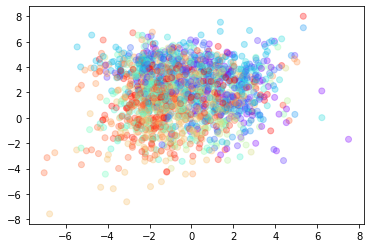

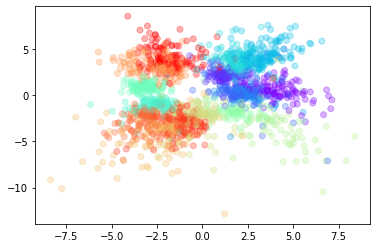

In [25]:
#user_map = y_user[train_gesture_map==1].argmax(axis=1) == 0

new_data_embeddings = tf.concat([tf.keras.backend.random_normal(shape=(len(train_embeddings), new_vae.latent_dim)), train_embeddings], 1)

print(new_data_embeddings.shape)
new_data = new_vae.decoder(new_data_embeddings)

new_embs = embedding_model.embedding(new_data)

fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(new_embs[:,0], new_embs[:,1] ,  cmap="rainbow", c = labels_train[train_map].argmax(axis=1), alpha=0.3 )
plt.show()

fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(train_embeddings[:,0], train_embeddings[:,1],  cmap="rainbow", c = labels_train[train_map].argmax(axis=1), alpha=0.3 )
plt.show()

## Running tests on all users

In [10]:
def get_eer(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    #treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
    for c, threshold in enumerate(scores_legit):
        frr = c * 1.0 / len(scores_legit)
        adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
        far = 1 - (adv_index * 1.0 / len(scores_adv))
        if frr >= far:
            return threshold, far
    print("Failure")

def get_eer_recogblind(scores_legit, scores_adv_typed, total_w, total_b, total_i):
	scores_legit = sorted(scores_legit)
	scores_adv_typed = sorted(scores_adv_typed, key = lambda x:x[0])
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv_typed) if x[1][0] > threshold), len(scores_adv_typed))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			rejectrate_w = 0 if 0 == total_w else len([i for i in scores_adv_typed if 'W' == i[1] and i[0] >= threshold]) / total_w
			rejectrate_b = 0 if 0 == total_b else len([i for i in scores_adv_typed if 'B' == i[1] and i[0] >= threshold]) / total_b
			rejectrate_i = 0 if 0 == total_i else len([i for i in scores_adv_typed if 'I' == i[1] and i[0] >= threshold]) / total_i
			return threshold, far, rejectrate_w, rejectrate_b, rejectrate_i

def get_far_when_zero_frr(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
    for c, threshold in enumerate(scores_legit):

        frr = c * 1.0 / len(scores_legit)
        adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
        far = 1 - (adv_index * 1.0 / len(scores_adv))
        if frr > 0.001:
            return threshold, far
        


In [9]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)


vae = WAE_stats(10)

x_features = vae.vae_featurize(x_data)


feature_data_train = x_features[(train_gesture_map == 1)]
labels_train = y_user[(train_gesture_map == 1)]

feature_data_test = x_features[(test_gesture_map == 1)]
labels_test = y_user[test_gesture_map == 1]

scaler = StandardScaler()
feature_data_train = scaler.fit_transform(feature_data_train)
feature_data_test = scaler.transform(feature_data_test)


In [11]:
embedders = {}
vaes = {}

In [13]:

model_name = "RF"
reps = 3

gestures_per_terminal = 1


gestures_to_generate = 500

generate_ml_models = True


results = {}


for extra_data in [False] : #, True]:
    precisions = []
    recalls = []
    fmeasures = []
    aurocs = []
    eers = []
    fars = []
    for auth_user in range(16):

        print(auth_user)

        auth_map = (labels_train.argmax(axis=1) != auth_user)


        user_feature_data_train = feature_data_train[auth_map]
        user_labels_train = labels_train[auth_map]

        single_labels_test = labels_test.argmax(axis=1) == auth_user

        if extra_data:
            if generate_ml_models:
                
                embedding_model = EmbeddingModel(54, 2)
                embedding_model.compile(Adam())

                embedding_model.fit(user_feature_data_train,user_labels_train,
                                    epochs=300, batch_size=128, verbose=0)
                embedders[auth_user] = embedding_model

                train_embeddings = embedding_model.embedding(user_feature_data_train)
                
                new_vae = cVAE_features(10, feature_data_train.shape[1], 2)
                new_vae.beta = 1e-4
                new_vae.compile(Adam())
                new_vae.fit(user_feature_data_train, train_embeddings,
                        epochs=500, batch_size=128, verbose=1)
                new_vae.save_model(f"no_{auth_user}", "vae_features")
                vaes[auth_user] = new_vae
                
            else:
                new_vae = vaes[auth_user]
                embedding_model = embedders[auth_user]
            

        user_gestures = []

        for terminal_type in [3,4,5,6,7,8,9]: # ,4,5,6,7,8,9]:
            specific_gestures = x_features[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) & (y_gesture.argmax(axis=1) == terminal_type)]
            user_gestures.append(specific_gestures[:gestures_per_terminal])

        user_specific_data = np.concatenate(user_gestures + [])
        user_specific_data = scaler.transform(user_specific_data)
        
        
        if extra_data:

            repeated_user_specific_data = np.concatenate([user_specific_data] * (gestures_to_generate // (gestures_per_terminal)))
            user_embeddings = embedding_model.embedding(repeated_user_specific_data)
            user_embeddings = user_embeddings + 0.5*tf.keras.backend.random_normal(shape=user_embeddings.shape)
            
            print(user_embeddings)
            
            new_data_embeddings = tf.concat([tf.keras.backend.random_normal(shape=(len(repeated_user_specific_data), new_vae.latent_dim)), user_embeddings], 1)
            new_data = new_vae.decoder(new_data_embeddings)

            single_label_train = np.concatenate([np.zeros(len(user_feature_data_train)), np.ones(len(user_specific_data) + len(new_data))])
            user_feature_data_train = np.concatenate([user_feature_data_train, user_specific_data, new_data])

        else:
            single_label_train = np.concatenate([np.zeros(len(user_labels_train)), np.ones(len(user_specific_data))])
            user_feature_data_train = np.concatenate([user_feature_data_train, user_specific_data])

        fmeasures.append([])
        aurocs.append([])
        eers.append([])
        fars.append([])
        
        for rep in range(reps): 

            if model_name == "RF":
                model = RandomForestClassifier(n_estimators = 100, random_state = reps, class_weight="balanced").fit(user_feature_data_train, single_label_train)
                labels_pred = model.predict(feature_data_test)
                labels_scores = model.predict_proba(feature_data_test)[:, 1]
            elif model_name == "MLP":
                clf = make_pipeline( StandardScaler(), MLPClassifier(solver='adam', alpha=1e-3,
                                         hidden_layer_sizes=(50,20, 2), random_state=rep)) # ,class_weight="balanced")) # ,
                clf.fit(user_feature_data_train, single_label_train)

                labels_pred = clf.predict(feature_data_test)
                labels_scores = clf.predict_proba(feature_data_test)[:, 1]

            #precision = precision_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
            #recall = recall_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
            fmeasure = f1_score(single_labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) # macro vs binary
            auroc = sklearn.metrics.roc_auc_score(single_labels_test, labels_scores, average = "macro", labels = np.unique(labels_pred))

            
            scores_legit = [labels_scores[i] for i in range(len(single_labels_test)) if 1 == single_labels_test[i]]
            scores_adv = [labels_scores[i] for i in range(len(single_labels_test)) if 0 == single_labels_test[i]]
            eer_theta, eer = get_eer(scores_legit, scores_adv)
            far_theta, far = get_far_when_zero_frr(scores_legit, scores_adv)
            
            print("eer theta", eer_theta)
            print("far_theta", far_theta)
            
            fmeasures[auth_user].append(fmeasure)
            aurocs[auth_user].append(auroc)
            eers[auth_user].append(eer)
            fars[auth_user].append(far)

    if extra_data:
        key = "extra_data"
    else:
        key = "normal"
    results[key] = {"fmeasure": fmeasures, "auroc": aurocs, "eer":eers, "far":fars}

0


AxisError: axis 1 is out of bounds for array of dimension 1

In [17]:
stat = "far"
display(np.mean(np.array(results["normal"][stat])))
display(np.mean(np.array(results["extra_data"][stat])))

0.1394148320731038

0.7669723867826116

In [128]:
for auth_user in range(16):
    embedding_model = embedders[0]
    new_embs = embedding_model.embedding(feature_data_train)

    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(projection='3d') # ) # embs[:, 2],

    ax.scatter(new_embs[:,0], new_embs[:,1] , new_embs[:,2], cmap="rainbow", c = labels_train.argmax(axis=1) == auth_user, alpha=0.3 )

    plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## INTENT VERSION!

# INTENT VERSION

In [18]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)


vae = WAE_stats(10)

x_features = vae.vae_featurize(x_data)

train_map = (train_gesture_map == 1) | (y_gesture.argmax(axis=1) != 0)
feature_data_train = x_features[train_map]
data_train = x_data[train_map]
labels_train = y_intent[train_map]

test_map = (test_gesture_map == 1) | (y_gesture.argmax(axis=1) == 0)
feature_data_test = x_features[test_map]
data_test = x_data[test_map]
labels_test = y_intent[test_map]

scaler = StandardScaler()
feature_data_train = scaler.fit_transform(feature_data_train)
feature_data_test = scaler.transform(feature_data_test)


In [24]:

model_name = "DL"
reps = 1

gestures_per_terminal = 500


gestures_to_generate = 500

generate_ml_models = False
extra_data = False

results = {}

precisions = []
recalls = []
fmeasures = []
aurocs = []
eers = []
fars = []
for auth_user in range(16):

    print(auth_user)

    auth_map = (y_user[train_map].argmax(axis=1) != auth_user)


    user_feature_data_train = feature_data_train[auth_map]
    user_labels_train = labels_train[auth_map]

    single_labels_test = y_user[test_map].argmax(axis=1) == auth_user

    if extra_data:
        if generate_ml_models:

            embedding_model = EmbeddingModel(54, 2)
            embedding_model.compile(Adam())

            embedding_model.fit(user_feature_data_train,user_labels_train,
                                epochs=300, batch_size=128, verbose=0)
            embedders[auth_user] = embedding_model

            train_embeddings = embedding_model.embedding(user_feature_data_train)

            new_vae = cVAE_features(10, feature_data_train.shape[1], 2)
            new_vae.beta = 1e-4
            new_vae.compile(Adam())
            new_vae.fit(user_feature_data_train, train_embeddings,
                    epochs=500, batch_size=128, verbose=1)
            new_vae.save_model(f"no_{auth_user}", "vae_features")
            vaes[auth_user] = new_vae

        else:
            new_vae = vaes[auth_user]
            embedding_model = embedders[auth_user]


    user_gestures = []

    for terminal_type in [3,4,5,6,7,8,9]: # ,4,5,6,7,8,9]:
        specific_gestures = x_features[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) & (y_gesture.argmax(axis=1) == terminal_type)]
        user_gestures.append(specific_gestures[:gestures_per_terminal])

    user_specific_data = np.concatenate(user_gestures + [])
    user_specific_data = scaler.transform(user_specific_data)


    if extra_data:

        repeated_user_specific_data = np.concatenate([user_specific_data] * (gestures_to_generate // (gestures_per_terminal)))
        user_embeddings = embedding_model.embedding(repeated_user_specific_data)
        user_embeddings = user_embeddings + 0.5*tf.keras.backend.random_normal(shape=user_embeddings.shape)

        print(user_embeddings)

        new_data_embeddings = tf.concat([tf.keras.backend.random_normal(shape=(len(repeated_user_specific_data), new_vae.latent_dim)), user_embeddings], 1)
        new_data = new_vae.decoder(new_data_embeddings)

        single_label_train = np.concatenate([np.zeros(len(user_feature_data_train)), np.ones(len(user_specific_data) + len(new_data))])
        user_feature_data_train = np.concatenate([user_feature_data_train, user_specific_data, new_data])

    else:
        single_label_train = np.concatenate([np.zeros(len(user_labels_train)), np.ones(len(user_specific_data))])
        user_feature_data_train = np.concatenate([user_feature_data_train, user_specific_data])

    fmeasures.append([])
    aurocs.append([])
    eers.append([])
    fars.append([])

    for rep in range(reps): 

        if model_name == "RF":
            model = RandomForestClassifier(n_estimators = 100, random_state = reps, class_weight="balanced").fit(user_feature_data_train, single_label_train)
            labels_pred = model.predict(feature_data_test)
            labels_scores = model.predict_proba(feature_data_test)[:, 1]
        elif model_name == "MLP":
            clf = make_pipeline( StandardScaler(), MLPClassifier(solver='adam', alpha=1e-3,
                                     hidden_layer_sizes=(50,20, 2), random_state=rep)) # ,class_weight="balanced")) # ,
            clf.fit(user_feature_data_train, single_label_train)

            labels_pred = clf.predict(feature_data_test)
            labels_scores = clf.predict_proba(feature_data_test)[:, 1]
        elif model_name == "DL":
            model = get_new_auth_model((200,6), 1, "sigmoid")

            model.compile(Adam(), loss="binary_crossentropy")

            model.fit(data_train,labels_train, validation_split = 0.2, epochs=15, batch_size=128)
            
            labels_scores = model.predict(data_test)
            labels_pred = labels_scores >= 0.5

        #precision = precision_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
        #recall = recall_score(labels_test, labels_pred, average = "macro", labels = np.unique(labels_pred))
        fmeasure = f1_score(single_labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) # macro vs binary
        auroc = sklearn.metrics.roc_auc_score(single_labels_test, labels_scores, average = "macro", labels = np.unique(labels_pred))


        scores_legit = [labels_scores[i] for i in range(len(single_labels_test)) if 1 == single_labels_test[i]]
        scores_adv = [labels_scores[i] for i in range(len(single_labels_test)) if 0 == single_labels_test[i]]
        eer_theta, eer = get_eer(scores_legit, scores_adv)
        far_theta, far = get_far_when_zero_frr(scores_legit, scores_adv)

        print("eer theta", eer_theta)
        print("far_theta", far_theta)

        fmeasures[auth_user].append(fmeasure)
        aurocs[auth_user].append(auroc)
        eers[auth_user].append(eer)
        fars[auth_user].append(far)

if extra_data:
    key = "extra_data"
else:
    key = "normal"
results[key] = {"fmeasure": fmeasures, "auroc": aurocs, "eer":eers, "far":fars}

0
Epoch 1/15
105/105 [==============================] - 9s 31ms/step - loss: 0.1943 - val_loss: 0.1415
Epoch 2/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0989 - val_loss: 0.1907
Epoch 3/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0914 - val_loss: 0.1426
Epoch 4/15
105/105 [==============================] - 2s 22ms/step - loss: 0.0867 - val_loss: 0.0819
Epoch 5/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0856 - val_loss: 0.1553
Epoch 6/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0839 - val_loss: 0.0991
Epoch 7/15
105/105 [==============================] - 2s 22ms/step - loss: 0.0795 - val_loss: 0.1752
Epoch 8/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0795 - val_loss: 0.0779
Epoch 9/15
105/105 [==============================] - 2s 21ms/step - loss: 0.0742 - val_loss: 0.0884
Epoch 10/15
105/105 [==============================] - 2s 22ms/step - loss: 0.0768 - val_

In [25]:
results

{'normal': {'fmeasure': [[0.0641509433962264],
   [0.05173169662428759],
   [0.04507170498520373],
   [0.06105144149236857],
   [0.06257197696737044],
   [0.07906741003547896],
   [0.061096136567834684],
   [0.07284079084287201],
   [0.05549568965517242],
   [0.04610951008645533],
   [0.09326424870466321],
   [0.11366711772665763],
   [0.10049539985845718],
   [0.08578745198463507],
   [0.09828009828009827],
   [0.10616929698708752]],
  'auroc': [[0.4799881990681438],
   [0.514547355929291],
   [0.5052575571574639],
   [0.7277906305017606],
   [0.4383647543585931],
   [0.7480552110647022],
   [0.42765283224772366],
   [0.3564896954068069],
   [0.49499858195504665],
   [0.9593842218404],
   [0.969511991634778],
   [0.9733962786347572],
   [0.967420314662043],
   [0.969931715402771],
   [0.9866123080666089],
   [0.9781795537147467]],
  'eer': [[0.5245422556211606],
   [0.4929521876409563],
   [0.48604726448688895],
   [0.3206976232394366],
   [0.548936170212766],
   [0.31151481274455006]

In [ ]:
vae = WAE_stats(10)


In [ ]:
x_features = vae.vae_featurize(x_data)

In [ ]:
x_train = x_features[train_gesture_map == 1].numpy().astype("float64")
y_train = y_user[train_gesture_map == 1]

In [ ]:
feature_data_train = x_features[(train_gesture_map == 1)]
labels_train = y_user[(train_gesture_map == 1)]
 # 
feature_data_test = x_features[(test_gesture_map == 1)]
labels_test = y_user[(test_gesture_map == 1)]


model = Model(feature_data_train.shape[1])
model.fit_scaler(feature_data_train)

model.compile(tf.optimizers.Adam())
model.fit(feature_data_train[labels_train.argmax(axis=1) >= 0], labels_train[labels_train.argmax(axis=1) >= 0], batch_size=128, epochs = 500)

In [ ]:
embs = model.embedding(model.transform_scaler(feature_data_train))
preds = model.classifier(embs)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot() # projection='3d') # embs[:, 2],

ax.scatter(embs[:,0], embs[:,1],  cmap="rainbow", c = labels_train.argmax(axis=1), alpha=0.3 )

fig.set_size_inches(18.5, 10.5)

In [ ]:


embs_test = model.embedding(model.transform_scaler(feature_data_test))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embs_test[:,0], embs_test[:,1], embs_test[:, 2], cmap="rainbow", c = labels_test.argmax(axis=1) == 0, alpha=0.3 )

fig.set_size_inches(18.5, 10.5)

labels_scores = model.classifier(embs_test)
labels_pred=  labels_scores.numpy().argmax(axis=1)
sum(labels_pred == labels_test.argmax(axis=1)) / len(labels_test)

In [ ]:
fmeasure